In [1]:
import random
from os import path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier

In [2]:
SEED = 491
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
data_path = "data/previous"
synthetic_path = path.join(data_path, "synthetic_patients.csv")
cohort_path = path.join(data_path, "processed_cohort_with_age.csv")

synthetic_dataset = pl.read_csv(synthetic_path)
cohort_dataset = pl.read_csv(cohort_path)

In [5]:
print("========== Train on Synthetic → Test on Cohort ==========")

label_col = "target"
X = synthetic_dataset.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y = synthetic_dataset.get_column(label_col).to_numpy().astype(np.int64).ravel()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

X_test = cohort_dataset.select(pl.exclude(label_col)).to_numpy().astype(np.float32)
y_test = cohort_dataset.get_column(label_col).to_numpy().astype(np.int64).ravel()

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

========== Train on Synthetic → Test on Cohort ==========


In [6]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=5000
    ),
    "SVM": SVC(
        kernel="rbf",
        C=0.5,
        gamma=0.01,
        probability=True,
        class_weight="balanced",
        random_state=SEED
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=1200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        class_weight="balanced_subsample",
        random_state=SEED,
        n_jobs=-1,
    ),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=SEED,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    ),
}

In [7]:
results = []
roc_curves = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, auc, acc, prec, rec, f1])
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves.append((name, fpr, tpr, auc))

In [8]:
input_size = X_train.shape[1]
hidden_size = 64
nn_model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 2),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

In [9]:
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_data = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [10]:
best_val_auc = 0
for epoch in range(50):
    nn_model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    nn_model.eval()
    with torch.no_grad():
        y_true, y_pred = [], []
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = nn_model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(probs)
        val_auc = roc_auc_score(y_true, y_pred)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = nn_model.state_dict()

nn_model.load_state_dict(best_model_state)
nn_model.eval()
with torch.no_grad():
    y_true, y_pred = [], []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = nn_model(X_batch)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = np.argmax(outputs.cpu().numpy(), axis=1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(probs)

In [11]:
auc = roc_auc_score(y_true, y_pred)
y_bin = (np.array(y_pred) >= 0.5).astype(int)
acc = accuracy_score(y_true, y_bin)
prec = precision_score(y_true, y_bin)
rec = recall_score(y_true, y_bin)
f1 = f1_score(y_true, y_bin)
results.append(["Neural Network", auc, acc, prec, rec, f1])
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_curves.append(("Neural Network", fpr, tpr, auc))

In [12]:
df_results = pl.DataFrame(results, schema=["Model", "AUC", "Accuracy", "Precision", "Recall", "F1"], orient="row")
display(df_results)

Model,AUC,Accuracy,Precision,Recall,F1
str,f64,f64,f64,f64,f64
"""Logistic Regression""",0.829702,0.811224,0.444444,0.352941,0.393443
"""SVM""",0.83878,0.75,0.394366,0.823529,0.533333
"""Random Forest""",0.813544,0.770408,0.382979,0.529412,0.444444
"""XGBoost""",0.785585,0.77551,0.391304,0.529412,0.45
"""Neural Network""",0.805192,0.816327,0.454545,0.294118,0.357143


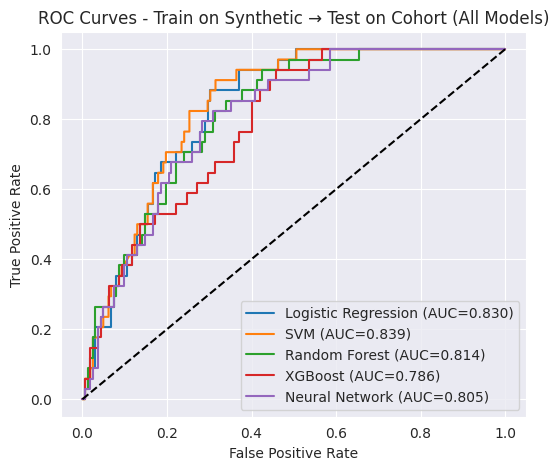

In [13]:
plt.figure(figsize=(6, 5))
for name, fpr, tpr, auc in roc_curves:
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Train on Synthetic → Test on Cohort (All Models)")
plt.legend()
plt.show()